## Тестовое Mashine Learning

Необходимо написать нейросеть, которая распознаёт буквы на изображении. 
Распознанные буквы записать в текстовый файл. Код, все необходимые зависимости и 
остальные необходимые файлы загрузить в открытый репозиторий на GitHub. 
Желательно не забыть про комментарии в коде. Датасет и изображение, на котором необходимо 
распознать буквы приложены.

### Процесс решения задачи

Загружаем необходимые библиотеки.

In [1]:
import os
import cv2
import random
import imutils
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

Посмотрим из чего состоят наши данные.

In [2]:
sample_path = r'dataset\test (копия)\Ф'

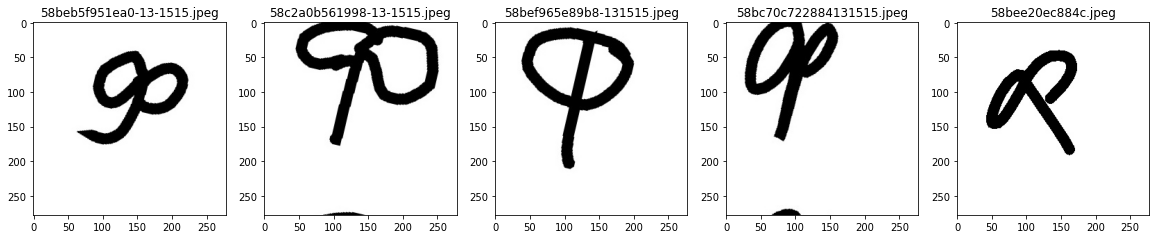

In [3]:
fig = plt.figure(figsize=(20, 20))
for i in range(5):
    file = random.choice(os.listdir(sample_path))
    image_path = os.path.join(sample_path, file)
    img = mpimg.imread(image_path)
    ax = plt.subplot(1, 5, i+1)
    ax.title.set_text(file)
    plt.imshow(img)
print()

Проверим размер картинки.

In [4]:
img = mpimg.imread(os.path.join(sample_path, random.choice(os.listdir(sample_path))))

In [5]:
img.shape

(278, 278, 3)

Теперь займемся обнаружением букв на целевом изображении. Посмотрим что оно из себя представляет.

In [6]:
image_file = 'IMG.JPG'
image = cv2.imread(image_file)

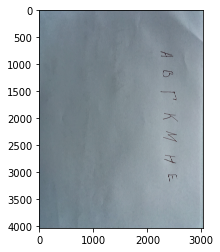

In [7]:
imgplot = plt.imshow(image)
plt.show()

Подготовим предоставленное изображение.

In [8]:
resized_image = cv2.resize(image, (600, 800))                          # изменяем размер изображения
rotated_image = imutils.rotate(resized_image, 90)                      # поворачиваем изображение
gray = cv2.cvtColor(rotated_image, cv2.COLOR_BGR2GRAY)                 # делаем изображение серым
ret, thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)         # убираем шумы
img_erode = cv2.erode(thresh, np.ones((3, 3), np.uint8), iterations=1) # обводим буквы

Найдем все контуры на целевом изображении.

In [9]:
contours, hierarchy = cv2.findContours(img_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) 

Функция для извлечения и сохранения букв на изображении.

In [10]:
def extract_and_save_letters(contours, hierarchy, folder_to_extract):
    
    '''
        The function extracts letters from the contours and hierarchy provided, 
        and saves them separetly.
    
    '''
    
    for idx, contour in enumerate(contours):
        (x, y, w, h) = cv2.boundingRect(contour)
        if hierarchy[0][idx][3] == 0:                                   # условие для выделения букв
            letter = np.array(img_erode[y-15:y+h+15, x-15:x+w+15], np.uint8)
            cv2.imwrite(os.path.join(folder_to_extract, 'image_'+str(idx)+'.jpg'), letter)

In [11]:
extract_and_save_letters(contours, hierarchy, folder_to_extract = r'test\subfolder')

Создадим необходимые для обучения нейронной сети функции.

In [12]:
def load_train(path):
    
    '''The function loads train data from the specified path.'''

    train_datagen = ImageDataGenerator(
                                       validation_split=0.25,
                                       rescale = 1./255,
                                       # horizontal_flip=True, 
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       )

    train_flow = train_datagen.flow_from_directory( 
                                                   directory = path,
                                                   target_size=(48, 48),
                                                   subset='training',
                                                   batch_size=16,
                                                   class_mode='categorical',
                                                   seed=42,
                                                   shuffle=True,
                                                   color_mode='grayscale'
                                                   )

    return train_flow

In [13]:
def load_validation(path):
    
    '''The function loads validation data from the specified path.'''
    
    validation_datagen = ImageDataGenerator(
                                            validation_split=0.25, 
                                            rescale = 1./255
                                            )
    validation_flow = validation_datagen.flow_from_directory(
                                                             directory = path,
                                                             target_size=(48, 48),
                                                             subset='validation',
                                                             batch_size=16,
                                                             class_mode='categorical',
                                                             seed=42,
                                                             shuffle=True,
                                                             color_mode='grayscale'
                                                             )

    return validation_flow

In [14]:
def load_test(test_path):
    
    '''The function loads test data from the specified path.'''
    
    test_datagen = ImageDataGenerator( 
                                      rescale = 1./255
                                      )
    test_flow = test_datagen.flow_from_directory(
                                                 directory = test_path,
                                                 target_size=(48, 48),
                                                 batch_size=1,
                                                 class_mode='categorical',
                                                 shuffle=False,
                                                 color_mode='grayscale'
                                                 )
    
    return test_flow

In [15]:
data_path = r'dataset\test (копия)'

In [16]:
test_path = r'test'

In [17]:
train = load_train(data_path);

Found 24888 images belonging to 33 classes.


In [18]:
validation = load_validation(data_path);

Found 8288 images belonging to 33 classes.


In [19]:
test = load_test(test_path)

Found 7 images belonging to 1 classes.


Проектируем нейронную сеть.

In [20]:
def create_model(input_shape):
    
    '''
        The function creates neural network model with provided layers. 
        Input shape - shape of the image as (height, width, channels)
    
    '''
    
    model = Sequential()
    
    model.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
    
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    
    model.add(Dense(330, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(33, activation='softmax'))

    optimizer = Adam(lr=0.0003)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

Размер изображений уменьшен для увеличения скорости обучения.

In [21]:
input_shape = (48, 48, 1)

In [22]:
model = create_model(input_shape)

Обучаем модель. Сохраняем веса самой успешной эпохи обучения нейронной сети.

In [23]:
def train_model(model, train_data, validation_data, batch_size=None, epochs=30, steps_per_epoch=None, validation_steps=None):
    
    '''The function trains neural network model. Also creates a file with weights of the best model.'''

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(validation_data)
        
    weights_file = 'weights.hdf5'
    metric = 'val_accuracy'
    checkpoint = ModelCheckpoint(weights_file, monitor=metric, mode='max', save_best_only=True, verbose=2)

    model.fit(train_data, validation_data=validation_data, 
              batch_size=batch_size, epochs=epochs, 
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True, callbacks=[checkpoint])

    return model

In [24]:
# train_model(model, train, validation, batch_size=16)

Теперь у нас нет необходимости обучать модель заново.

In [25]:
model.load_weights('weights.hdf5')

Протестируем полученную модель.

In [26]:
nb_samples = len(test.filenames)
predict = model.predict(test, steps = nb_samples)
predicted_class_indices = np.argmax(predict, axis=1)

In [27]:
labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

Как видим, все буквы распознаны верно. Порядок изменен в связи с особенностями нахождения контуров на изображении.

In [28]:
predictions

['В', 'А', 'Н', 'Г', 'М', 'Е', 'К']

Запишем результат в текстовый файл.

In [29]:
with open('result.txt', 'w') as file:
    file.write(str(predictions))